# Predicción Univariada y Multivariada de los Principales Índices Financieros del Mundo

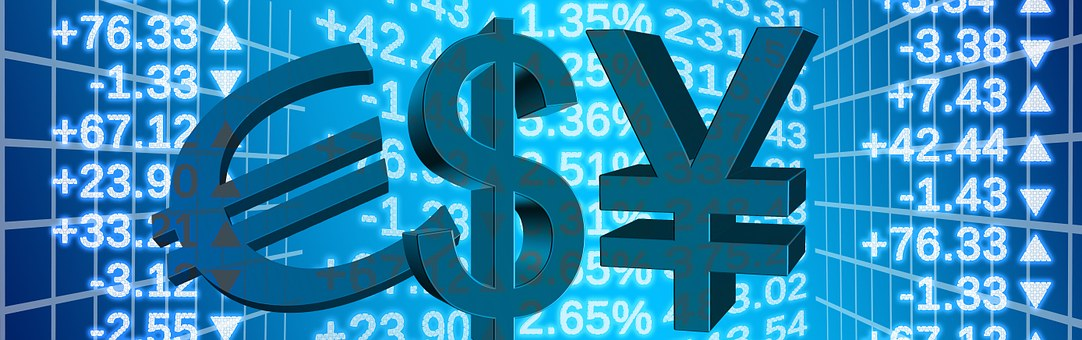

In [1]:
from IPython.display import Image
Image(filename='./img/imagenStock.jpg' ,  width= 1280)

### Carga de bibliotecas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sb
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

### Carga del dataset

In [3]:
df = pd.read_csv("./inputs/dataset.csv", index_col=0, parse_dates=True, dayfirst= True)
df.head()

,MERV,BVSP,GSPC,NDX,FTSE,GDAXI,FCHI,N225,HSI,SSEC,BSESN,DEXARUS,DEXBZUS,DEXUSUK,DEXUSEU,DEXJPUS,DEXHKUS,DEXCHUS,DOLAR_BLUE
FECHA,,,,,,,,,,,,,,,,,,,
1997-07-02,824.109985,13260.0,904.030029,975.929993,4751.399902,3867.530029,2909.500000,20196.41992,NaN,1199.06,4333.899902,0.9998,1.0767,1.6670,1.1223,114.52,7.7472,8.3210,NaN
1997-07-03,831.440002,13285.0,916.919983,986.520020,4831.700195,3939.729980,2937.000000,20121.41016,15055.70020,1150.62,4323.459961,0.9994,1.0778,1.6885,1.1242,113.46,7.7445,8.3214,NaN
1997-07-04,837.950012,13494.0,NaN,NaN,4812.799805,3946.729980,2934.500000,19968.00000,14823.00000,1159.34,4323.819824,0.9995,NaN,NaN,1.1230,NaN,NaN,NaN,NaN
1997-07-07,841.690002,13502.0,912.200012,991.039978,4810.700195,4003.350098,2947.699951,19705.16992,14858.59961,1096.82,4291.450195,0.9998,1.0779,1.6870,1.1226,112.60,7.7428,8.3218,NaN
1997-07-08,846.330017,13617.0,918.750000,1005.809998,4758.500000,4030.100098,2929.800049,19853.89063,14792.20020,1109.67,4306.390137,0.9999,1.0790,1.6885,1.1180,112.76,7.7436,8.3219,NaN


### Transformaciones 

Aquí incluir el código desarrollado en TP2 para obtener las series transformadas (logaritmos naturales de los índices y tasas de retorno).

#### Preparamos el ambiente para obtener la serie de retornos y logaritmos de los índices.
Haremos un tratamiento de los datos similar al del práctico anterior. 

In [4]:
df = df[df.index.dayofweek < 5]

df_interpolate = df.copy()

for col in df.columns:
    
    df_temp = df[[col]]
    df_temp['new_index'] = np.array(range(len(df_temp)))
    
    df_temp_dropna=df_temp.dropna()

    y = np.array(df_temp[col])
    x = np.array(df_temp.new_index)

    y_dropna = np.array(df_temp_dropna[col])
    x_dropna = np.array(df_temp_dropna.new_index)
    
    f_lineal = interp1d(x_dropna, y_dropna, fill_value="extrapolate")
    f_cubic = interp1d(x_dropna, y_dropna, kind='cubic', fill_value="extrapolate")

    y_lineal = f_lineal(x)
    y_cubic = f_cubic(x)
    
    df_interpolate[col] = y_cubic
    del df_temp, df_temp_dropna, x, y, x_dropna, y_dropna, f_lineal, f_cubic, y_lineal, y_cubic

In [5]:
df = df_interpolate.copy()

In [6]:
cepo_1 = (df.index >= '2011-10-28') & (df.index <= '2015-12-16')
cepo_2 = (df.index >= '2019-09-01') & (df.index <= '2020-05-08')
cepo = (cepo_1 | cepo_2)
df['DEXARUS'][cepo] = df['DOLAR_BLUE']

df_us = pd.DataFrame(index=df.index)
df_us['MERV'] = df['MERV'] / df['DEXARUS'] # Divido porque el par esta en X/US
df_us['BVSP'] = df['BVSP'] / df['DEXBZUS']
df_us['FTSE'] = df['FTSE'] * df['DEXUSUK'] # Multiplico porque el par esta en US/X
df_us['GDAXI'] = df['GDAXI'] * df['DEXUSEU']
df_us['FCHI'] = df['FCHI'] * df['DEXUSEU']
df_us['N225'] = df['N225'] / df['DEXJPUS']
df_us['HSI'] = df['HSI'] / df['DEXHKUS']
df_us['SSEC'] = df['SSEC'] / df['DEXCHUS']
# df_us['BSESNUS'] = df['BSESN'] / df['DEX?'] Falta el DEX de rupias indias? 

#A continuación agregamos los índices GSPC y NDX.
df_us['GSPC'] = df['GSPC']
df_us['NDX'] = df['NDX']

#### Definimos los dataframes df_ret y df_ln

In [7]:
df_ret = df_us.pct_change().replace(np.nan,0)
df_ln = np.log(df_us)

In [8]:
df_ret.head()

,MERV,BVSP,FTSE,GDAXI,FCHI,N225,HSI,SSEC,GSPC,NDX
FECHA,,,,,,,,,,
1997-07-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997-07-03,0.009298,0.000863,0.030016,0.020393,0.011161,0.005594,-0.060765,-0.040444,0.014258,0.010851
1997-07-04,0.007729,0.015781,-0.003102,0.000707,-0.001918,-0.001982,-0.015259,0.007547,-0.003921,0.000044
1997-07-07,0.004162,0.000452,-0.002136,0.013985,0.004140,-0.011247,0.002421,-0.053943,-0.001231,0.004538
1997-07-08,0.005412,0.007489,-0.009971,0.002557,-0.010145,0.006118,-0.004572,0.011704,0.007180,0.014904


In [9]:
df_ln.head()

,MERV,BVSP,FTSE,GDAXI,FCHI,N225,HSI,SSEC,GSPC,NDX
FECHA,,,,,,,,,,
1997-07-02,6.714504,9.418606,8.977220,8.375751,8.091117,5.172511,7.635219,4.970511,6.806863,6.883391
1997-07-03,6.723759,9.419469,9.006794,8.395939,8.102216,5.178089,7.572529,4.929226,6.821020,6.894184
1997-07-04,6.731459,9.435127,9.003688,8.396646,8.100296,5.176106,7.557152,4.936744,6.817091,6.894227
1997-07-07,6.735612,9.435578,9.001550,8.410534,8.104428,5.164795,7.559571,4.881292,6.815859,6.898755
1997-07-08,6.741009,9.443040,8.991528,8.413088,8.094231,5.170894,7.554989,4.892927,6.823014,6.913548


# Trabajo Práctico N°4: Aprendizaje Supervisado

## Introducción

En los prácticos 1 y 2 se analizaron las series originales y se les realizaron diversas transformaciones. Luego, a partir de las series preprocesadas, en el práctico 3 se realizaron las divisiones de los conjuntos de datos y se obtuvieron los pronósticos _average_ y _naive_ y se comparó su desempeño con el de los modelos ARIMA.

Este práctico es una continuación del práctico 3. El objetivo principal de mismo es estimar modelos relativamente mas avanzados y comparar su desempeño con los trabajados previamente. 

Los modelos sugeridos son:

Modelos estadísticos multivariantes

#### Modelo VAR

Por un lado, se pueden considerar los modelos vectoriales autorregresivos (VAR) que son la extensión natural de los modelos ARMA para series multivariantes. Empleando los mismos se pueden modelar las tasas de rendimiento de varios índices financieros en forma simultánea. 

Formalmente, Se conoce como modelo de vectores autorregresivos a un proceso estocástico $k$-dimensional $x_t$ tal que

$$x_t= A_1 x_{t-1} +...+A_p x_{t-p} + u_t,$$

donde las $A_i$, para $i= 1,...,p$, son matrices de orden $k \times k$ y $u_t$ es un proceso ruido blanco de dimensión $k$; o sea que $E(u_t)=0$, $E(u_t u_t') = \Sigma_u$ y $E(u_tu_s)=0$ para $s \neq t$.[Mas detalles](https://otexts.com/fpp2/VAR.html)

#### Modelos VECM

En caso de estimar modelos para series no estacionarias, como es el caso de los logaritmos naturales de los retornos, los modelos VAR no son adecuados por razones similares a las estudiadas en el caso de los modelos ARIMA. Se podría aplicar un modelo VAR para las series diferenciadas, pero para no perder la información sobre las potenciales relaciones de largo plazo entre dichas series es recomendable trabajar con modelos vectoriales de corrección de errores (VECM). 

Formalmente:

Dado el modelo VAR no estacionario (o sea que las series componetes de $y_t$ son no estacionarias) $$y_t= A_1 y_{t-1}+...+A_p y_{t-p}+ u_t,$$

el mismo puede ser reescrito en forma de Modelo de Corrección de Errores (VECM) $$\Delta y_t=\Pi y_{t-1}+ \Gamma_1 \Delta y_{t-1}+...+\Gamma_p \Delta y_{t-p+1}+ u_t.$$

Siendo  $\Pi = -(I_k - A_1 - ... - A_p)$, $r(\Pi)= r$, con $0 \leq r \leq k$, $u_t \sim N(0, \Sigma_u)$ y las $\Gamma_i=-(A_{i+1}+...+A_p)$, para $i=1,...,p-1$ son matrices de parámetros de orden $k \times k$. Si $\Pi$ tiene rango $r$, puede ser expresada como el producto $\alpha \beta'$, siendo $\alpha$ y $\beta$ matrices de orden $k\times r$ de rango $r$. En dicho caso, se dice que el proceso $y_t$ es cointegrado con rango $r$. Las matrices $\beta$ y $\alpha$ son conocidas como matriz de cointegración y matriz de cargas, respectivamente.

La importancia de la representación en forma de modelo de correción de errores radica en que permite expresar a $\Delta y_t$ como la suma de dos componentes (aparte de $u_t$): 1) $\Pi y_{t-1}$ que muestra relaciones de equilibrio de largo plazo y 2) $\Gamma_1 \Delta y_{t-1}+...+\Gamma_p \Delta y_{t-p+1}$ que capta el ajuste de corto plazo.

Respecto a las relaciones de largo plazo, las mismas son conocidas como relaciones de cointegración y consisten en combinaciones lineales estacionarias $z_t=\beta'y_t$ de las series $y_t$ (las cuales son no estacionarias).

#### LSTM

Las redes Long Short Term Memory son un caso particular de las Redes Neuronales Recurrentes y buscan reolver el problema del decaimiento del gradiente. Por lo general las referencias son bastante confusas, pero estos enlaces son relativamente claros: [Link1](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) - [Link2](https://medium.com/@jcrispis56/introducci%C3%B3n-al-deep-learning-parte-3-redes-neuronales-recurrentes-7da543c3b181).



## Consignas


A partir de las series transformadas (logaritmos naturales de los índices y tasas de retorno), se proponen actividades orientadoras y algunos links con "ayudas", sin perjuicio de que se puedan incorporar análisis adicionales y consultar otras fuentes. 

Es recomendable realizar la división entre datos de entrenamiento y test usando un punto fijo en el tiempo para reducir la carga computacional. En forma opcional luego se puede implementar lo mismo con Walk-Forward Validation.

**Se pide:**

#### Modelo VAR

Entrenar un modelo VAR para las series correspondientes a los retornos de los índices. [Documentación](https://www.statsmodels.org/stable/vector_ar.html?highlight=var#module-statsmodels.tsa.vector_ar.var_model) - [Material complementario](https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/).

Hiperparámetros a considerar:

* El hiperparámetro mas importante es $p$, o sea la cantidad de retardos.
* Otro hiperparámetro es la especificación de la parte determinística, o sea si se incluye una constante, o una tendencia determinística.

La selección de los hiperparámetros se puede basar en las métricas previamente usadas: Error Cuadrático Medio, Error Absoluto Medio y Error Absoluto Mediano, o en criterios de información. 
 
#### Modelo VECM

Entrenar un modelo VECM para los logaritmos de los índices. [Documentación](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.VECM.html).

Hiperparámetros:

* La cantidad de retardos.
* Especificación de la parte determinística.
* Cantidad de relaciones de cointegración.

La selección de los hiperparémetros se puede realizar como en el modelo VAR, aunque en el caso de la cantidad de relaciones de cointegración es usual emplear la [Prueba de Johansen](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.coint_johansen.html?highlight=statsmodels%20tsa%20vector_ar%20vecm%20coint_johansen#statsmodels.tsa.vector_ar.vecm.coint_johansen).

#### LSTM

Entrenar una red neuronal tipo LSTM univariante. [Ayuda](https://towardsdatascience.com/how-not-to-predict-stock-prices-with-lstms-a51f564ccbca).

Entrenar una red neuronal tipo LSTM multivariante. [Ayuda](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/).
    
#### Evaluar el desempeño de los modelos. ¿Se pudo superar a los modelos "baseline"?

**Opcional:**

Implementar un procedimiento en dos etapas para combinar las estimaciones de un modelo VAR con LSTM (para las tasas de rendimiento) y comparar el desempeño con los de LSTM y VAR.
[Descripción del procecimiento](https://towardsdatascience.com/combine-lstm-and-var-for-multivariate-time-series-forecasting-abdcb3c7939b) - [Código](https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/LSTM_VAR/LSTM_VAR.ipynb).

## Fecha de entrega

- __Versión preliminar: 11/10__ 

- __Version final: 18/10__

## Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis realizado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver tal como los compañeros de clase. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 


# Desarrollo

In [10]:
target = 'MERV'

## Hacemos split de datos en train, test y validation

In [11]:
def percentage_split_data(data, percentage_val, percentage_test):
    percentage_train = 100 - percentage_val - percentage_test

    total_rows = len(data.index)
    train_rows = int(round(total_rows * percentage_train / 100))
    val_rows = int(round(total_rows * percentage_val / 100))
    test_rows = int(round(total_rows * percentage_test / 100))
    
    train_data = data[:train_rows]
    val_data = data[train_rows:-test_rows]
    test_data = data[-test_rows:]

    return train_data, val_data, test_data

In [12]:
ret_train_data, ret_val_data, ret_test_data = percentage_split_data(df_ret, 10, 20)
ln_train_data, ln_val_data, ln_test_data = percentage_split_data(df_ln, 10, 20)

n_test = len(ret_test_data.index)

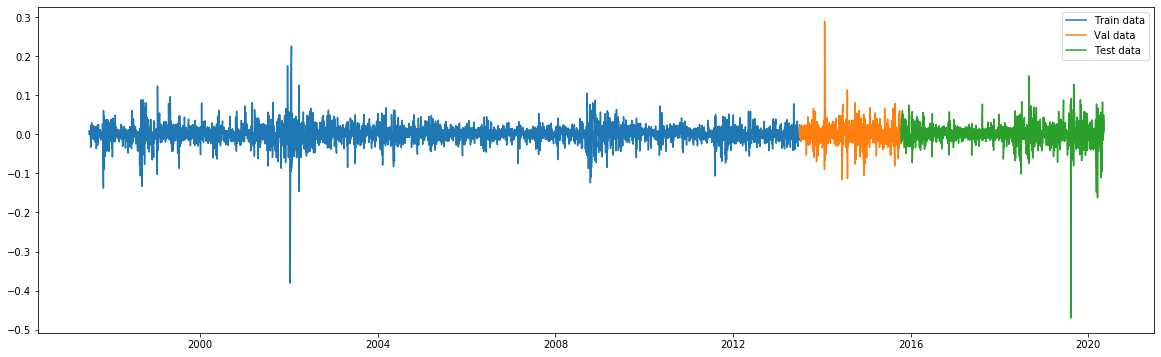

In [13]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(ret_train_data.index,ret_train_data[target], label='Train data')
ax.plot(ret_val_data.index, ret_val_data[target], label='Val data')
ax.plot(ret_test_data.index, ret_test_data[target], label='Test data')
ax.legend()
plt.show()

## Modelo VAR

### Definimos funcion que calcula el mse pasado un max lags usando los datos de validación

In [14]:
def get_var_mse(max_lags:int, col):
    var_model = VAR(ret_train_data)
    var_model_results = var_model.fit(maxlags=max_lags)
    var_model_lag_order = var_model_results.k_ar
    var_model_forecast_input_data = ret_val_data.values[-var_model_lag_order:]
    var_model_pred = var_model_results.forecast(y=var_model_forecast_input_data, steps=len(ret_val_data.index))
    var_model_pred = (pd.DataFrame(var_model_pred, index=ret_val_data.index, columns=ret_val_data.columns + '_pred'))
    mse = mean_squared_error(ret_val_data[col], var_model_pred[f'{col}_pred'])
    return mse


In [15]:
results = pd.DataFrame(columns=['max_lags', 'mse'])
for max_lags in range(10, 21):
    mse = get_var_mse(max_lags, target)
    results = results.append({'max_lags': max_lags, 'mse': mse}, ignore_index=True)
ordered_results = results.sort_values(by=['mse', 'max_lags']).reset_index(drop=True)
ordered_results

,max_lags,mse
0,20.0,0.000843
1,19.0,0.000844
2,17.0,0.000844
3,16.0,0.000844
4,18.0,0.000844
5,13.0,0.000844
6,12.0,0.000844
7,14.0,0.000845
8,10.0,0.000845
9,11.0,0.000845


### Buscamos el mejor max lags

In [16]:
best_max_lags = ordered_results.iloc[0]['max_lags']
best_max_lags = int(best_max_lags)
best_max_lags

20

### Predecimos el valor en los datos de test

In [17]:
var_model = VAR(ret_train_data)
var_model_results = var_model.fit(maxlags=best_max_lags)
var_model_lag_order = var_model_results.k_ar
var_model_forecast_input_data = ret_test_data.values[-var_model_lag_order:]
var_model_pred = var_model_results.forecast(y=var_model_forecast_input_data, steps=len(ret_test_data.index))
var_model_pred = (pd.DataFrame(var_model_pred, index=ret_test_data.index, columns=ret_test_data.columns + '_pred'))
mse = mean_squared_error(ret_test_data[target], var_model_pred[f'{target}_pred'])

In [18]:
var_model_pred

,MERV_pred,BVSP_pred,FTSE_pred,GDAXI_pred,FCHI_pred,N225_pred,HSI_pred,SSEC_pred,GSPC_pred,NDX_pred
FECHA,,,,,,,,,,
2015-10-14,0.006393,0.003734,-0.005430,0.005483,0.005814,0.003654,0.029056,0.008791,0.006816,0.001043
2015-10-15,-0.004483,-0.011284,-0.004921,-0.000705,0.000764,-0.002974,-0.003469,-0.007610,-0.002179,-0.006194
2015-10-16,-0.007829,-0.007852,-0.011873,-0.007347,-0.006387,-0.008465,-0.008339,0.007196,-0.011774,-0.016271
2015-10-19,0.014939,0.025942,-0.008895,-0.001732,-0.003365,0.008893,0.007100,0.010052,0.000126,0.001718
2015-10-20,0.003131,-0.007333,-0.003741,-0.006051,-0.003410,-0.007114,-0.007685,0.000680,-0.003178,-0.003579
...,...,...,...,...,...,...,...,...,...,...
2020-05-04,0.000079,0.000460,0.000143,0.000338,0.000240,0.000073,0.000213,0.000320,0.000215,0.000434
2020-05-05,0.000079,0.000460,0.000143,0.000338,0.000240,0.000073,0.000213,0.000320,0.000215,0.000434
2020-05-06,0.000079,0.000460,0.000143,0.000338,0.000240,0.000073,0.000213,0.000320,0.000215,0.000434


### Calculamos las metricas para los datos de test

In [19]:
# Mean absolute error
mae = mean_absolute_error(ret_test_data[target], var_model_pred[f'{target}_pred'])
print('MAE: %f' % mae)

# Mean squared error
mse = mean_squared_error(ret_test_data[target], var_model_pred[f'{target}_pred'])
print('MSE: %f' % mse)

# Root mean squared error
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

MAE: 0.018192
MSE: 0.000861
RMSE: 0.029338


## Modelo VECM

El modelo 'Vector Error Correction Model' supone la no estacionalidad de las series, entonces es un modelo aplicable a las series de los Logaritmos.
Antes que nada, importamos la librería.

In [20]:
from statsmodels.tsa.api import VECM

Para conocer la cantidad de relaciones de cointegración (el 3er hiperparámetro del modelo VECM), lo que podemos hacer es el Test de Johansen.
Nuestro valor de medida, ya sea max_eigenvalue o trace_stat, debe ser mayor al valor crítico para poder rechazar la hipótesis nula que el número de correlaciones es menor o igual a n.
https://docs.w3cub.com/statsmodels/generated/statsmodels.tsa.vector_ar.vecm.coint_johansen/

In [21]:
# Example 14.3 Cointegration Test: The Johansen Approach 

data = df_ln

from statsmodels.tsa.vector_ar.vecm import coint_johansen

"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""

def joh_output(res):
    output = pd.DataFrame([res.lr1, res.lr2],
                          index=["trace_stat", 'max_eig_stat'])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat")
    for i in range(len(res.cvt)):
        print(i, res.cvt[i])
    print("\n")
    print("Critical values(90%, 95%, 99%) of max_eig_stat")
    for i in range(len(res.cvm)):
        print(i, res.cvm[i])
    print("--------------------------------------------------------------")


# Model 3 (2 lag-difference used = 3 lags VAR or VAR(3) model)
# with constant/trend (deterministc) term
joh_model3 = coint_johansen(data,0,2) # k_ar_diff +1 = K
joh_output(joh_model3)
# Model 2: with linear trend only
joh_model2 = coint_johansen(data,1,2) # k_ar_diff +1 = K
joh_output(joh_model2)

# Model 1: no constant/trend (deterministc) term
joh_model1 = coint_johansen(data,-1,2) # k_ar_diff +1 = K
joh_output(joh_model1)

   trace_stat  max_eig_stat
0  222.994557     60.226823
1  162.767733     46.488569
2  116.279164     41.612700
3   74.666464     19.875803
4   54.790661     17.547156
5   37.243506     14.252003
6   22.991503      9.973592
7   13.017911      6.896086
8    6.121825      5.475145
9    0.646680      0.646680 

Critical values(90%, 95%, 99%) of trace_stat
0 [232.103  239.2468 253.2526]
1 [190.8714 197.3772 210.0366]
2 [153.6341 159.529  171.0905]
3 [120.3673 125.6185 135.9825]
4 [ 91.109   95.7542 104.9637]
5 [65.8202 69.8189 77.8202]
6 [44.4929 47.8545 54.6815]
7 [27.0669 29.7961 35.4628]
8 [13.4294 15.4943 19.9349]
9 [2.7055 3.8415 6.6349]


Critical values(90%, 95%, 99%) of max_eig_stat
0 [61.2041 64.504  71.2525]
1 [55.2412 58.4332 64.996 ]
2 [49.2855 52.3622 58.6634]
3 [43.2947 46.2299 52.3069]
4 [37.2786 40.0763 45.8662]
5 [31.2379 33.8777 39.3693]
6 [25.1236 27.5858 32.7172]
7 [18.8928 21.1314 25.865 ]
8 [12.2971 14.2639 18.52  ]
9 [2.7055 3.8415 6.6349]
---------------------------

## CONSULTAR 
Tengo que elegir Cantidad de relaciones de cointegracion = 1 ?? Links: https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com , http://cruncheconometrix.blogspot.com/2018/03/time-series-analysis-lecture-4-part-1.html
Está bien hacer el Test de Johansen con todos los datos? O hacerlo solamente con los datos de entrenamiento ?

Encontré otra forma de evaluar el Test de Johansen: https://towardsdatascience.com/vector-autoregressions-vector-error-correction-multivariate-model-a69daf6ab618

In [22]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
vec_rank1 = select_coint_rank(ln_train_data, det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.01)
print(vec_rank1.summary())
vec_rank2 = select_coint_rank(ln_train_data, det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.01)
print(vec_rank2.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0  10          305.7          273.4
  1  10          211.2          228.2
-------------------------------------
Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          94.45          74.74
  1   2          51.81          68.50
-------------------------------------


Toda la informacion del modelo fiteado está en un objeto de la clase VECMResults: https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.VECMResults.html#statsmodels.tsa.vector_ar.vecm.VECMResults

### Determinando hiperparametros con los datos de Validacion

In [23]:
def get_hiperp(hiperp:int, col):
    model = VECM(endog = ln_train_data, k_ar_diff = hiperp, coint_rank = 1)
    model_results = model.fit()
    model_pred = model_results.predict(steps=len(ln_val_data.index))
    model_pred = (pd.DataFrame(model_pred, index=ln_val_data.index, columns=ln_val_data.columns + '_pred'))

    # Mean squared error
    mse = mean_squared_error(ln_val_data[col], model_pred[f'{col}_pred'])
    return mse

In [24]:
results = pd.DataFrame(columns=['hiperp', 'mse'])
for hiperp in range(1, 20):
    mse = get_hiperp(hiperp, target)
    results = results.append({'hiperp': hiperp, 'mse': mse}, ignore_index=True)
ordered_results = results.sort_values(by=['mse', 'hiperp']).reset_index(drop=True)
ordered_results

,hiperp,mse
0,19.0,0.288589
1,16.0,0.293410
2,15.0,0.297737
3,14.0,0.297993
4,17.0,0.302300
5,18.0,0.302946
6,2.0,0.330694
7,11.0,0.331764
8,12.0,0.335164
9,1.0,0.335547


In [25]:
best_hiperp = ordered_results.iloc[0]['hiperp']
best_hiperp = int(hiperp)
hiperp

19

In [26]:
new_train = pd.concat([ln_train_data, ln_val_data])

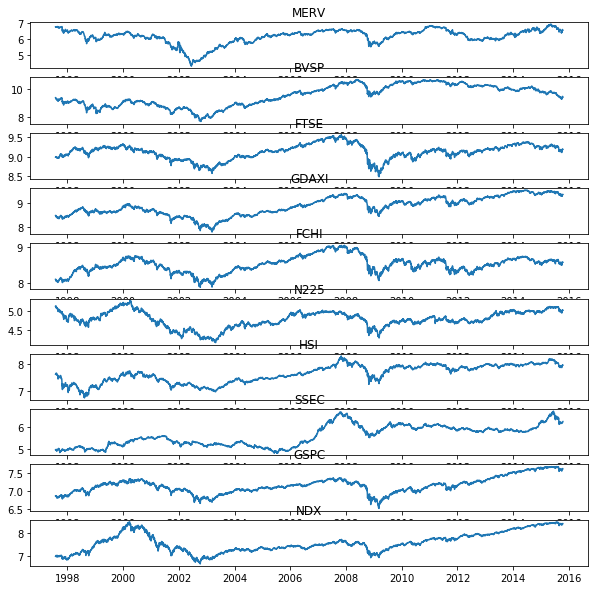

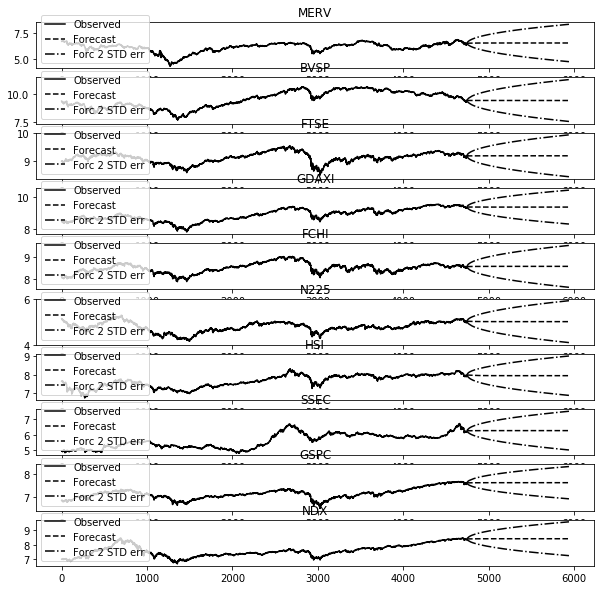

In [27]:
model = VECM(endog = new_train, k_ar_diff = hiperp, coint_rank = 1)
model_results = model.fit()
model_results.plot_data()
model_results.plot_forecast(n_test)

In [28]:
#print(model_results.summary())

In [29]:
model_pred = model_results.predict(steps=n_test)
model_pred = (pd.DataFrame(model_pred, index=ln_test_data.index, columns=ln_test_data.columns + '_pred'))

In [30]:
model_pred

,MERV_pred,BVSP_pred,FTSE_pred,GDAXI_pred,FCHI_pred,N225_pred,HSI_pred,SSEC_pred,GSPC_pred,NDX_pred
FECHA,,,,,,,,,,
2015-10-14,6.531624,9.420186,9.176588,9.343516,8.572624,5.021618,7.976022,6.257701,7.605491,8.377604
2015-10-15,6.532922,9.420740,9.176463,9.342741,8.571803,5.020628,7.973685,6.256471,7.603797,8.377489
2015-10-16,6.541177,9.423720,9.176576,9.341627,8.570558,5.017511,7.972878,6.255330,7.602590,8.376355
2015-10-19,6.545018,9.432740,9.180256,9.345152,8.572883,5.018548,7.974026,6.253993,7.603196,8.377432
2015-10-20,6.546581,9.436888,9.184676,9.346067,8.575760,5.019787,7.975631,6.250704,7.604398,8.376159
...,...,...,...,...,...,...,...,...,...,...
2020-05-04,6.573759,9.449445,9.185564,9.344838,8.585583,5.008786,7.940856,6.265872,7.614590,8.402624
2020-05-05,6.573759,9.449445,9.185564,9.344838,8.585583,5.008786,7.940856,6.265872,7.614590,8.402624
2020-05-06,6.573759,9.449445,9.185564,9.344838,8.585583,5.008786,7.940856,6.265872,7.614590,8.402624


In [31]:
# Mean absolute error
mae = mean_absolute_error(ln_test_data['MERV'], model_pred['MERV_pred'])
print('MAE: %f' % mae)

# Mean squared error
mse = mean_squared_error(ln_test_data['MERV'], model_pred['MERV_pred'])
print('MSE: %f' % mse)

# Root mean squared error
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

MAE: 0.406636
MSE: 0.223839
RMSE: 0.473117


Estuve probando con distintas combinaciones de "coint_rank" para ver si podía bajar el error, pero hasta ahora la mejor fue coint_rank = 1. Coincide con el análisis que hice del Test de Johanson (no sé si estatá bien), asique supongo que es la mejor opción del hiperparámetro. Pero, eso quiere decir que solo 2 series de las 10 que tenemos están correlacionadas, lo cual me hace un poco de ruido porque Sergio dijo que los mercados están relacionados entre sí.
Analizando las métricas de error de los modelos Baseline (Average y Naive) para la serie de logaritmos (ver abajo), podemos ver que no podemos mejorar las predicciones de dichos modelos base.

1. model_average_mean_squared_error :  0.28174
2. model_average_mean_absolute_error :  0.42556
3. model_average_median_absolute_error :  0.36331
4. model_naive_mean_squared_error :  0.00067
5. model_naive_mean_absolute_error :  0.01637
6. model_naive_median_absolute_error :  0.01121

## Modelo LSTM UNIVARIANTE

### Normalizamos los datos

In [32]:
#Dividimos la muestra
df = df_us[['MERV']].copy()

# Split data into train and test
train, test = df.iloc[0:-200], df.iloc[-200:len(df)]

train_max = train.max()
train_min = train.min()

# Normalize the dataframes
train = (train - train_min)/(train_max - train_min)
test = (test - train_min)/(train_max - train_min)

### Estructuramos los datos

In [33]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


time_steps = 10

X_train, y_train = create_dataset(train, train.MERV, time_steps)
X_test, y_test = create_dataset(test, test.MERV, time_steps)

### Creación del modelo y entrenamiento

In [35]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.LSTM(250, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    shuffle=False
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 250)               252000    
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 251       
Total params: 252,251
Trainable params: 252,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
180/180 [==============================] - 5s 27ms/step - loss: 0.0371
Epoch 2/50
180/180 [==============================] - 4s 24ms/step - loss: 0.0459
Epoch 3/50
180/180 [==============================] - 4s 24ms/step - loss: 0.0533
Epoch 4/50
180/180 [==============================] - 4s 24ms/step - loss: 0.0462
Epoch 5/50
180/180 [==============================] 

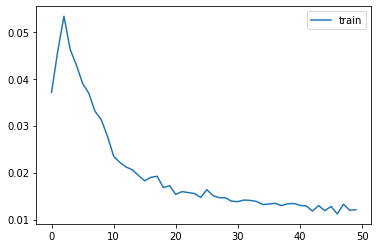

In [36]:
plt.plot(history.history['loss'], label='train')
plt.legend();
plt.show()

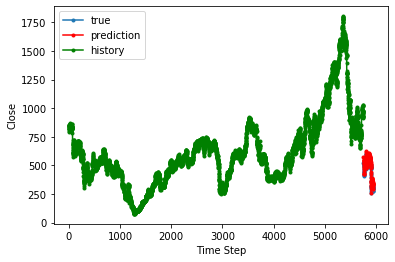

In [37]:
y_pred = model.predict(X_test)


# Rescale the data back to the original scale
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]


# Plotting the results
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred.flatten(), 'r', marker='.', label="prediction")
plt.plot(np.arange(0, len(y_train)), y_train.flatten(), 'g', marker='.', label="history")
plt.ylabel('Close')
plt.xlabel('Time Step')
plt.legend()
plt.show()

## MODELO LSTM MULTIVARIANTE

### MULTIPLE PARALLEL SERIES
The case where there are multiple parallel time series and a value must be predicted for each.
Leer más acá: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

### Exploración de los Datos

In [38]:
from matplotlib import pyplot

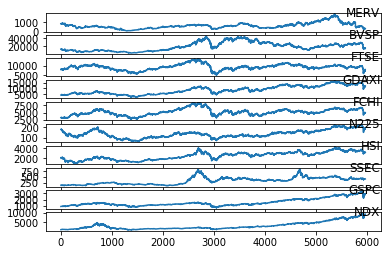

In [39]:
dataset = df_us
values = dataset.values

# specify columns to plot
groups = range(0,10)
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

### Preparación de los Datos

In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = df_us
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)
reframed.head(10)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1)
1,0.433356,0.238956,0.335156,0.134430,0.045790,0.722410,0.357964,0.030828,0.083960,0.019216
2,0.437791,0.239206,0.361304,0.140641,0.051157,0.728709,0.320768,0.022619,0.088717,0.020404
3,0.441512,0.243782,0.358521,0.140861,0.049480,0.726465,0.311995,0.024089,0.087390,0.020408
4,0.443531,0.243915,0.356611,0.145210,0.052331,0.713754,0.313366,0.013504,0.086975,0.020911
5,0.446168,0.246122,0.347710,0.146016,0.046629,0.720590,0.310772,0.015676,0.089393,0.022568
6,0.445611,0.248875,0.346077,0.145770,0.050822,0.709642,0.307435,0.017565,0.085255,0.023049
7,0.445757,0.245837,0.349228,0.145137,0.048641,0.711812,0.312647,0.017464,0.087558,0.023042
8,0.448798,0.235740,0.357964,0.145824,0.043610,0.710744,0.327117,0.023343,0.088629,0.023668
9,0.440270,0.225804,0.365917,0.149897,0.040926,0.731746,0.332426,0.028569,0.089256,0.026614
10,0.423979,0.202120,0.367392,0.149587,0.042435,0.702291,0.336940,0.030991,0.091980,0.028537


### Definir Modelo

In [41]:
# split into train and test sets
values = reframed.values
train, test = values[0:-200], values[-200:len(values)]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5762, 1, 9) (5762,) (200, 1, 9) (200,)


Epoch 1/50
81/81 - 1s - loss: 0.0744 - val_loss: 0.1301
Epoch 2/50
81/81 - 0s - loss: 0.1718 - val_loss: 0.2755
Epoch 3/50
81/81 - 0s - loss: 0.1126 - val_loss: 0.2126
Epoch 4/50
81/81 - 0s - loss: 0.0889 - val_loss: 0.1693
Epoch 5/50
81/81 - 0s - loss: 0.0832 - val_loss: 0.2107
Epoch 6/50
81/81 - 0s - loss: 0.0743 - val_loss: 0.2035
Epoch 7/50
81/81 - 0s - loss: 0.0608 - val_loss: 0.2180
Epoch 8/50
81/81 - 0s - loss: 0.0533 - val_loss: 0.1784
Epoch 9/50
81/81 - 0s - loss: 0.0477 - val_loss: 0.1338
Epoch 10/50
81/81 - 0s - loss: 0.0469 - val_loss: 0.1114
Epoch 11/50
81/81 - 0s - loss: 0.0496 - val_loss: 0.1198
Epoch 12/50
81/81 - 0s - loss: 0.0533 - val_loss: 0.1476
Epoch 13/50
81/81 - 0s - loss: 0.0528 - val_loss: 0.1629
Epoch 14/50
81/81 - 0s - loss: 0.0483 - val_loss: 0.1774
Epoch 15/50
81/81 - 0s - loss: 0.0464 - val_loss: 0.1797
Epoch 16/50
81/81 - 0s - loss: 0.0421 - val_loss: 0.1675
Epoch 17/50
81/81 - 0s - loss: 0.0388 - val_loss: 0.1419
Epoch 18/50
81/81 - 0s - loss: 0.0433 - 

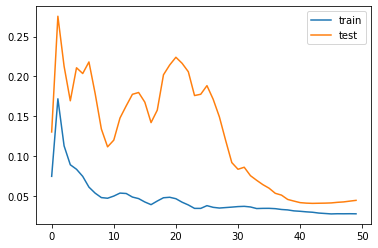

In [43]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()